TU Delft internship of Bordeaux ENSEIRB -MATMECA student Anouchka Desmettre 
Dates: June 1st - August 31st, 2024 

Supervision: D. Lahaye (DIAM - EEMCS Faculty - TU Delft)

# Title: Mathematical modelling and numerical simulation of driving buses and vibrations door   

## 5. Stationary Thin Beam Equation - Biharmonic Equation - Deflection 

### The bi-harmonic equation

The bi-harmonic equation in the context of a non-stationary thin beam typically describes the deflection of the beam. It can be expressed as:

$$
EI \times \nabla^4 u = \frac{\partial^2 u}{\partial t^2} + S
$$

In this equation:
- $\nabla^4$ represents the biharmonic operator.
- $u$ denotes the displacement.
- $E$ is the Young's modulus, and $I$ is the moment of inertia of the beam or plate.
- $\frac{\partial^2 u}{\partial t^2}$ is the second derivative of displacement with respect to time, indicating the acceleration.
- $S$ stands for any external source terms or forces acting on the system.

This equation provides a comprehensive model for predicting how beams bend and flex under such forces.

### Stationary behavior 

Before addressing the dynamic, non-stationary behavior, we first need to solve the stationary form of the equation in 2D, which simplifies to:

$$
EI \times \nabla^4 u = S 
$$

This stationary equation describes the beam's deflection under static loads in two dimensions, where time-dependent effects are not considered. Solving this will give us insight into the fundamental bending behavior of the beam under steady-state conditions.

### External source forces

To model a single force acting on the beam, we use a Gaussian function for the source term $S$. This function will have a maximum value $A$ representing the magnitude of the force, a width parameter $\sigma$, and be centered at position $x_0$ on the beam.

$$
EI \times (\frac{\partial^4 u}{\partial x^4} + 2\frac{\partial^4 u}{\partial x^2 \partial y^2} + \frac{\partial^4 u}{\partial y^4}) = A \exp \left( -\frac{(x - x_0)^2 + (y - y_0)^2)}{2\sigma^2} \right)
$$

This stationary equation describes the beam's deflection under static loads in two dimensions, where time-dependent effects are not considered. Solving this will give us insight into the fundamental bending behavior of the beam under steady-state conditions.

In [1]:
using Plots
using BenchmarkTools
using BoundaryValueDiffEq
using OrdinaryDiffEq

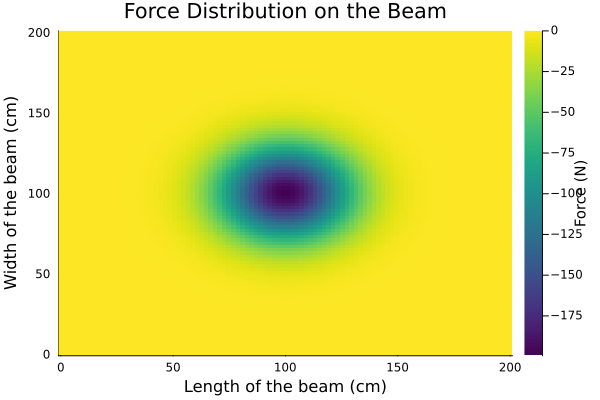

In [2]:
# Parameters
Nx = 100
Ny = 100
l = 200.0
dx = l / Nx
dy = l / Ny
E = 1.9 * 10^7
I = 117.8
EI = E*I

# Function to define the 2D source function
function source_function_2d(x, y)
    X0 = 100.0
    Y0 = 100.0
    σ  = 20
    A  = 200.0
    return -A * exp(-((x - X0)^2 + (y - Y0)^2) / (2*σ^2))
end

# Function to generate the source grid in 2D
function source_2d(Nx, Ny)
    l = 200.0
    dx = l / Nx
    dy = l / Ny
    X_vect = range(0, stop = l, length = Nx)
    Y_vect = range(0, stop = l, length = Ny)
    f = [source_function_2d(x, y) for y in Y_vect, x in X_vect]
    return X_vect, Y_vect, f
end

# Generate the 2D force distribution
X, Y, force_distribution = source_2d(Nx, Ny)

# Plotting the 2D force distribution
heatmap(X, Y, force_distribution, xlabel="Length of the beam (cm)", ylabel="Width of the beam (cm)", c=:viridis, colorbar_title="Force (N)", title="Force Distribution on the Beam")


### 5.1 Analytical Reference Solution

We find an analytical solution through: [Wikipedia - Fundamental Solution](https://en.wikipedia.org/wiki/Fundamental_solution#Biharmonic_equation).

The biharmonic equation can be written as:
$$
-\nabla^4 u(\mathbf{x}, \mathbf{x}') = \delta(\mathbf{x} - \mathbf{x}')
$$
In this equation:
- $\nabla^4$ is the biharmonic operator.
- $u(\mathbf{x}, \mathbf{x}')$ is the fundamental solution.
- $\delta(\mathbf{x} - \mathbf{x}')$ is the Dirac delta function, representing a point source of influence at the position $\mathbf{x}'$.

The fundamental solutions vary depending on the dimension of the space in which the equation is solved:

1. **In 2 dimensions (2D)**:
   $$
   u_{\text{2D}}(\mathbf{x}, \mathbf{x}') = -\frac{|\mathbf{x} - \mathbf{x}'|^2}{8\pi} \ln |\mathbf{x} - \mathbf{x}'
   $$
   Here, the solution shows that the influence of the point source decreases logarithmically with distance and is modulated by the square of the distance.

2. **In 3 dimensions (3D)**:
   $$
   u_{\text{3D}}(\mathbf{x}, \mathbf{x}') = \frac{|\mathbf{x} - \mathbf{x}'|}{8\pi}
   $$
   This form indicates a decrease in the influence of the source proportional to the distance, a characteristic typical of interactions in 3 dimensions, like gravitational or electrostatic fields in free space.

Now, let's discuss the shooting method. This method, useful for solving boundary value problems numerically, does not directly yield the previous fundamental solutions of the biharmonic equation which is derived using analytical techniques for a point source in an infinite domain.

However, the shooting method can be employed to determine analytical solutions for specific boundary value problems in finite domains.

### 5.2. Shooting Method Implementation

1. **What is BoundaryValueDiffEq?** 

BoundaryValueDiffEq is a Julia package specifically designed to solve boundary value problems (BVPs) for ordinary differential equations (ODEs). BVPs require solutions to differential equations where conditions are specified at different points, typically at the domain's boundaries, unlike initial value problems where conditions are only given at the start point.

2. **Role of the Shooting Method in BoundaryValueDiffEq**

The shooting method, implemented in the BoundaryValueDiffEq package, is one approach to solve BVPs. Here's how we proceed:

- Initial Guess: Start with an initial guess for the unknown initial conditions at one boundary.
- Solve Forward: Use an ODE solver to integrate the differential equation from one boundary to the other.
- Adjust Guess: Adjust the initial conditions based on the difference between the computed endpoint and the specified boundary condition at the final boundary.
- Iterate: Repeat the process, refining the initial conditions until the solution converges to satisfy the boundary conditions at both ends.

3. **Implementing the Shooting Method in Code**

We will extend the approach to solve the biharmonic equation using the shooting method from 1D to 2D using : https://github.com/Youkrid/Youkrid.github.io. 

To solve the biharmonic equation numerically in 2D, we transform it into a system of first-order ODEs.

- Discretization of the Biharmonic Operator

For discretization, we use finite difference approximations for the partial derivatives.

Fourth Derivative : 

$$
\frac{\partial^4 u}{\partial x^4} \approx \frac{u[i+2, j] - 4u[i+1, j] + 6u[i, j] - 4u[i-1, j] + u[i-2, j]}{dx^4}
$$

$$
\frac{\partial^4 u}{\partial y^4} \approx \frac{u[i, j+2] - 4u[i, j+1] + 6u[i, j] - 4u[i, j-1] + u[i, j-2]}{dy^4}
$$

$$
\frac{\partial^4 u}{\partial x^2 \partial y^2} \approx \frac{u[i+1, j+1] - 2u[i+1, j] + u[i+1, j-1] - 2u[i, j+1] + 4u[i, j] - 2u[i, j-1] + u[i-1, j+1] - 2u[i-1, j] + u[i-1, j-1]}{dx^2 dy^2}
$$

- Final Discretized Equation

The final discretization for $ du[i, j, 4] $ combines the second derivative terms and the source term:

$$
du[i, j, 4] = \frac{u[i+2, j] - 4u[i+1, j] + 6u[i, j] - 4u[i-1, j] + u[i-2, j]}{dx^4} + 
\frac{u[i, j+2] - 4u[i, j+1] + 6u[i, j] - 4u[i, j-1] + u[i, j-2]}{dy^4} + 2 
\frac{u[i+1, j+1] - 2u[i+1, j] + u[i+1, j-1] - 2u[i, j+1] + 4u[i, j] - 2u[i, j-1] + u[i-1, j+1] - 2u[i-1, j] + u[i-1, j-1]}{dx^2 dy^2} +
\frac{S}{E*I}$$

- Boundary conditions must be defined along the edges of the rectangular domain:

At $x = 0$ and $x = L$:
   $$
   u|_{x=0} = u_1 = 0
   $$
   $$
   \frac{\partial u}{\partial x}|_{x=0} = \frac{u_2 - u_1}{dx} = 0 \Rightarrow u_1 = u_2 = 0
   $$
   $$
   \frac{\partial u}{\partial x}|_{x=L} = \frac{u_{N+1} - u_N}{dx} = 0 \Rightarrow u_{N+1} = u_N = 0
   $$
   $$
   u|_{x=L} = u_{N+1} = 0
   $$

At $y = 0$ and $y = L$:
   $$
   u|_{y=0} = u_1 = 0
   $$
   $$
   \frac{\partial u}{\partial y}|_{y=0} = \frac{u_2 - u_1}{dy} = 0 \Rightarrow u_1 = u_2 = 0
   $$
   $$
   \frac{\partial u}{\partial y}|_{y=L} = \frac{u_{N+1} - u_N}{dy} = 0 \Rightarrow u_{N+1} = u_N = 0
   $$
   $$
   u|_{y=L} = u_{N+1} = 0
   $$

We will use the same principles but extend them to 2D. The parameters are those of an 80cm copper beam. We will iteratively solve the 2D problem to match the boundary conditions.

In [15]:
# Define the 2D biharmonic PDE as a system of first-order ODEs
function biharmonic_2d_pde!(du, u, p, t)
    Nx, Ny = size(u, 1), size(u, 2)
    for i in 3:Nx-2                         # Iterate over each point in the interior grid (excluding the edges)
        for j in 3:Ny-2
            du[i, j, 1] = u[i, j, 2]        # u[i, j, k]: Represents the value of the k-th component of the state u at grid position (i,j)
            du[i, j, 2] = u[i, j, 3]
            du[i, j, 3] = u[i, j, 4]
            du[i, j, 4] =  (u[i+2, j] - 4*u[i+1, j] + 6*u[i, j] - 4*u[i-1, j] + u[i-2, j]) / dx^4 +
                        (u[i, j+2] - 4*u[i, j+1] + 6*u[i, j] - 4*u[i, j-1] + u[i, j-2]) / dy^4 +
                        2 * (u[i+1, j+1] - 2*u[i+1, j] + u[i+1, j-1] - 2*u[i, j+1] + 4*u[i, j] - 2*u[i, j-1] + u[i-1, j+1] - 2*u[i-1, j] + u[i-1, j-1]) / (dx^2 * dy^2) +
                        source_function_2d(i*dx, j*dy) / (EI)
        end
    end
end

# Define the 2D boundary conditions
function boundaries_2d!(residual, u, EI, t)
    Nx, Ny = size(u, 1), size(u, 2)
    # Apply boundary conditions on all edges of the 2D domain
    for i in 1:Nx
        residual[i, 1] = u[i, 1, 1]        # Deflection at y=0
        residual[i, Ny] = u[i, Ny, 1]      # Deflection at y=L
    end
    for j in 1:Ny
        residual[1, j] = u[1, j, 1]        # Deflection at x=0
        residual[Nx, j] = u[Nx, j, 1]      # Deflection at x=L
    end
end

# Set up and solve the 2D problem
function set_boundaries_2d(Nx, Ny)
    xspan = (0.0, 200.0)
    yspan = (0.0, 200.0)
    l = 200.0
    dx = l / Nx
    dy = l / Ny

    # Initial guess for the 2D problem
    u0 = zeros(Nx, Ny, 4)  
    println("Initial guess u0: ", u0)


    # Set up the BVP for 2D
    bvp2d = BVProblem(biharmonic_2d_pde!, boundaries_2d!, u0, xspan)
    println("BVProblem setup complete")

    sol2d = solve(bvp2d, Shooting(), dt = min(dx, dy))
    println("Solution complete: ", sol2d)

    # Extract the solution
    sol2d_deflection = [sol2d[i][1] for i in 1:length(sol2d)] # Extract the deflection component


    return sol2d_deflection
end


set_boundaries_2d (generic function with 1 method)

GeneralMIRK4() is the solver used for the boundary value problem, suitable for implicit methods and stiff systems, and dt = min(dx, dy) ensures a sufficiently small time step for accurate resolution.

In [16]:
# Performance testing for 2D
@btime set_boundaries_2d(100, 100)

Initial guess u0: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

LoadError: BoundsError: attempt to access 100×100×4 Array{Float64, 3} at index [5, 3]

### 5.3 Finite Difference Method on Uniform Spatial Mesh

https://github.com/ziolai/finite_element_electrical_engineering/tree/main  

Implementing the finite difference method on a uniform spatial mesh involves discretizing the bi-harmonic equation using second-order central differences (for accuracy) and solving the resulting system of equations iteratively. This method is straightforward to implement and can handle uniform geometries effectively.

1. **Discretizing the Biharmonic Equation in 2D** 

To solve this equation numerically, we discretize the domain into a grid with spacing \(dx\) and \(dy\) along the \(x\) and \(y\) directions, respectively.

The finite difference approximation for the biharmonic operator in 2D can be expressed as:

$$
\nabla^4 u \approx \frac{1}{dx^4} (u_{i+2,j} - 4u_{i+1,j} + 6u_{i,j} - 4u_{i-1,j} + u_{i-2,j}) + \frac{1}{dy^4} (u_{i,j+2} - 4u_{i,j+1} + 6u_{i,j} - 4u_{i,j-1} + u_{i,j-2}) + \frac{2}{dx^2 dy^2} (u_{i+1,j+1} - 2u_{i,j} + u_{i-1,j-1})
$$

This approximation allows us to discretize the biharmonic equation on a grid. Here, $u_{i,j}$ represents the displacement at the grid point $(i,j)$.

### 5.4 Finite Element Method on Non-uniform Spatial Mesh

The finite element method (FEM) on a non-uniform spatial mesh requires discretizing the domain into smaller, irregular elements. This method is more versatile than finite differences for handling complex geometries and material properties but requires careful implementation of basis functions and assembly of stiffness matrices.